**Hackathon Initial Data Preparation**

In [1]:
#Import numpy and pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read in the provided dataset - I will turn test_date into a date format too
data = pd.read_csv("data/corona_tested_individuals_ver_006.english.csv", parse_dates=True, low_memory=False)
data.test_date = pd.to_datetime(data.test_date)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   test_date            278848 non-null  datetime64[ns]
 1   cough                278596 non-null  float64       
 2   fever                278596 non-null  float64       
 3   sore_throat          278847 non-null  float64       
 4   shortness_of_breath  278847 non-null  float64       
 5   head_ache            278847 non-null  float64       
 6   corona_result        278848 non-null  object        
 7   age_60_and_above     151528 non-null  object        
 8   gender               259285 non-null  object        
 9   test_indication      278848 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 21.3+ MB


There are a lot of null values for age.  Let's see how many there are for each testing date.

age_60_and_above
NaN    0.456593
No     0.450794
Yes    0.092613
Name: proportion, dtype: float64

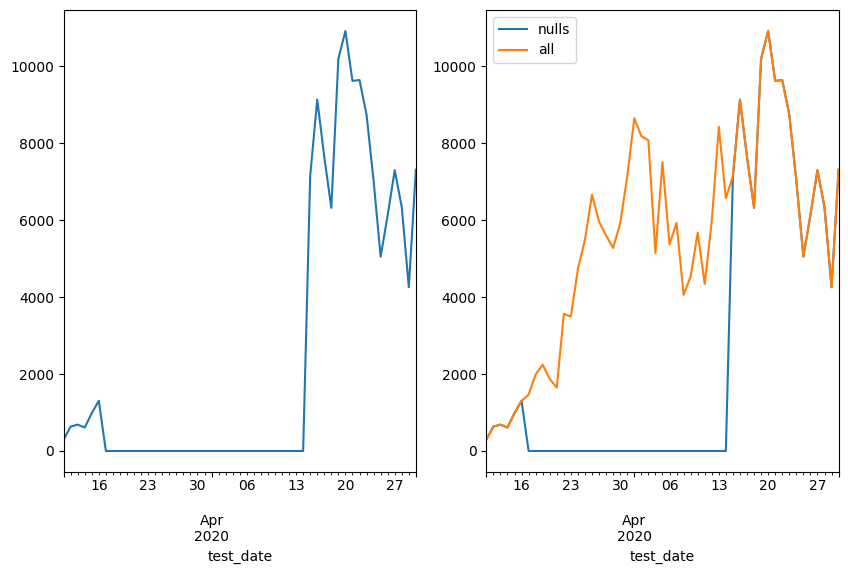

In [3]:
#This will plot the number of missing values by date
def check_col(column):
    check = data.copy()[["test_date", column]]
    check["nulls"] = check[column].isnull()
    check.drop(column, axis=1, inplace=True)
    check["all"] = 1
    check2 = check.groupby(["test_date"])[["nulls", "all"]].sum()
    fig, ax = plt.subplots(figsize=(10, 6), nrows=1, ncols=2)
    check2["nulls"].plot(ax=ax[0])
    
    check2.plot(ax=ax[1]);

check_col("age_60_and_above")
#Before 17th March and after 14th April we have missing values for age information


data.age_60_and_above.value_counts(dropna=False, normalize=True)

#This accounts for about 45% of our dataset!

There are other columns that have missing values, look at those too!

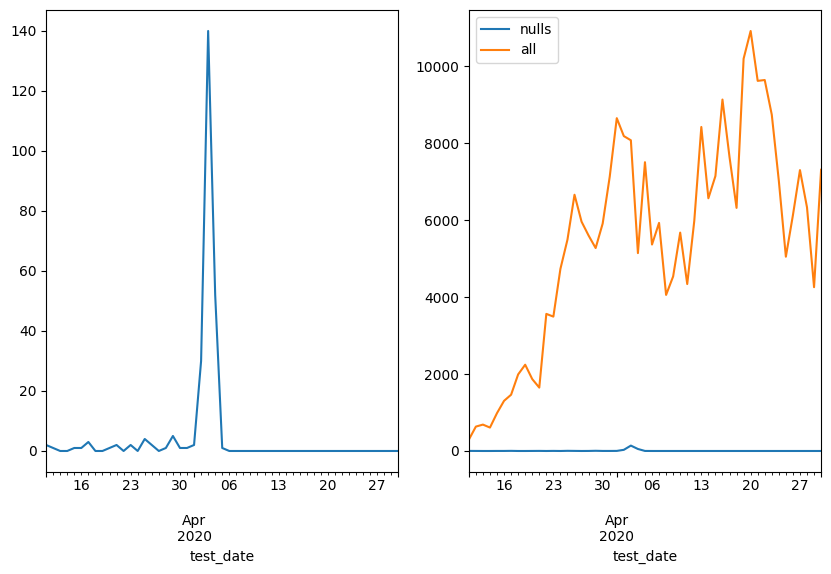

In [4]:
check_col("cough")

#There is a spike of missing data at the start of April
#It is unknown if this is due to a respondent not reporting either yes/no or due to an issue with collating the data
#There are a small number of missing observations before this spike too

#We can probably safely drop these observations to start with

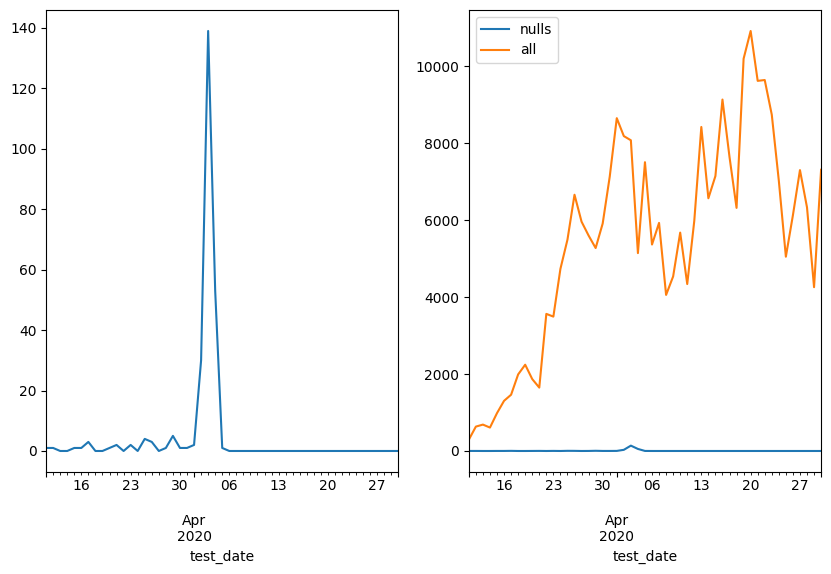

In [5]:
check_col("fever")

#This appears to be the same spike as with the cough data
#Indicates more likely an issue with data collection/collation.

#There are also some missing values before this spike as with cough, but not necessarily the same records

In [6]:
#Do these two columns align in that they are missing at the same time?
d = data[["cough", "fever", "test_date"]]
d.groupby(["cough", "fever"], dropna=False).count()

#Not a perfect match, but nearly.  
#There are 2 records that have a value for one column but not the other compared to 250 that are missing for both.

test_date
cough fever           
0.0   0.0       230092
      1.0         6276
1.0   0.0        26751
      1.0        15475
      NaN            2
NaN   0.0            1
      1.0            1
      NaN          250

In [7]:
data.fever.value_counts(dropna=False, normalize=True)

fever
0.0    0.921090
1.0    0.078007
NaN    0.000904
Name: proportion, dtype: float64

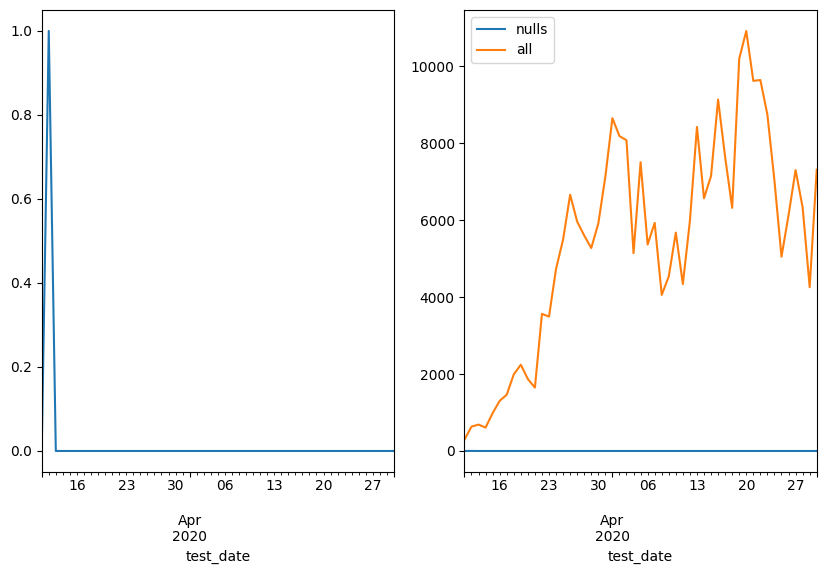

In [8]:
check_col("sore_throat")

#There is one missing record at the start of our dataset
#We can likely safely drop this due to the size of the data that we have available
#as this record is unlikely to be significantly different from others in our dataset

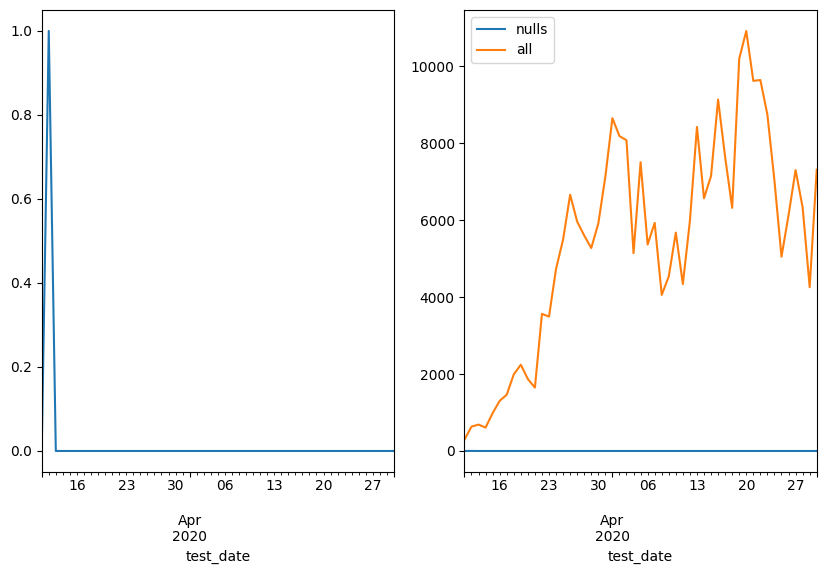

In [9]:
check_col("shortness_of_breath")

#Same as sore_throat

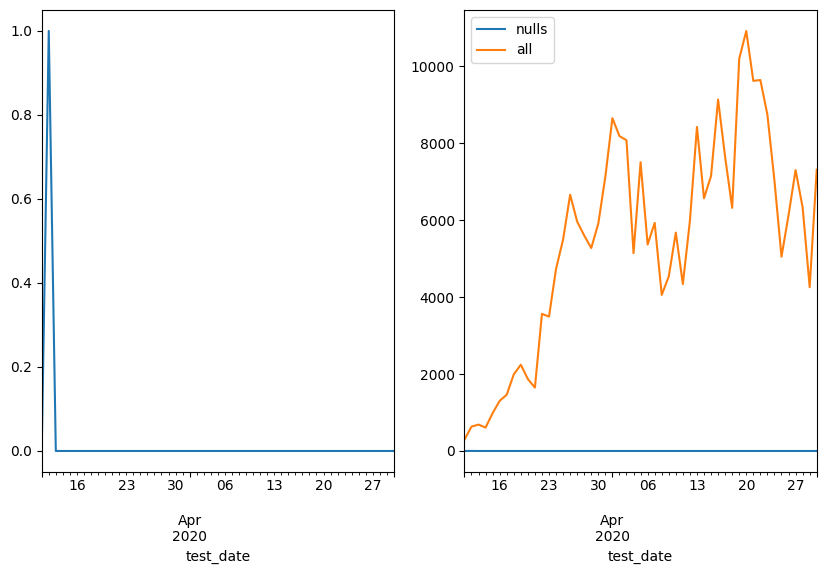

In [10]:
check_col("head_ache")

#Same as sore_throat

gender
female    0.466770
male      0.463073
NaN       0.070157
Name: proportion, dtype: float64

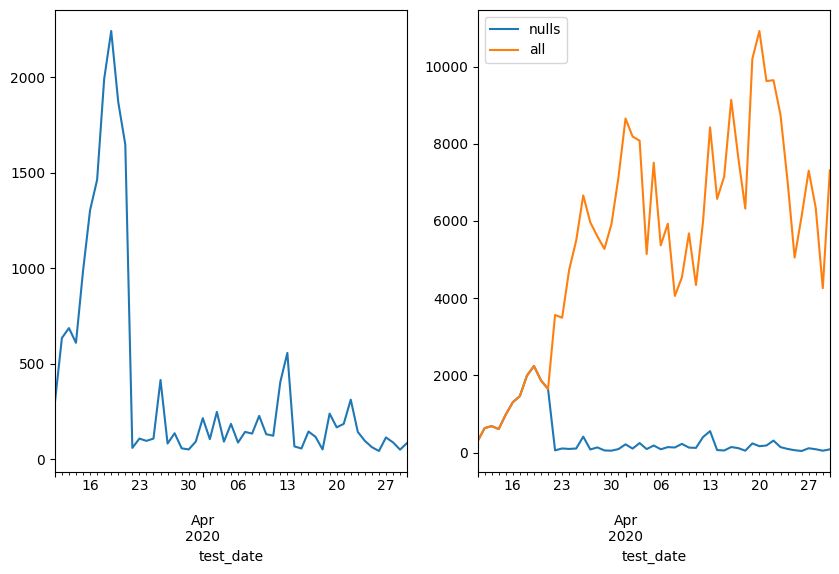

In [11]:
check_col("gender")

#This is more consistently missing throughout the dataset, but with a peak at the start

data.gender.value_counts(dropna=False, normalize=True)

#This accounts for about 7% of our dataset and is missing for all records before March 23rd.

**Summary**

Overall our dataset is relatively well populated.  There is one missing record for each of:

 - `sore_throat`
 - `shortness_of_breath`
 - `head_ache`

I think we can safely drop these records as they shouldn't significantly impact the quality or bias in the data that we have available.

For the following columns it looks like there was an issue with data collection as we see a spike in missing data for the same date of test results:

 - `cough`
 - `fever`
 
These are nearly a perfect overlap of records and it accounts for only comfortably less than 1% of the data and we can safely ignore these records.

We see more issues with the following two variables:

 - `age_60_or_over`
 - `gender`

For gender, it is only approximately 7% of the data that has a missing value.  We could probably drop these records and be okay, however for age it is more drastic with 45% of the data being missing.  I think a sensible approach here would be start by comapring a simple model built on only the full data with no missing values to look at the impact/importance of these two variables.  If they appear to be a significant predictor we would likely need to continue with this smaller dataset, however if they are not significant we could ignore these columns instead and keep more records to hopefully improve model performance.
 

In [12]:
#Create the filtered dataset dropping the missing records
data2 = data.dropna()

**Feature Engineering**

We have a few columns that are stored as text values.  We will need to encode them into a numeric form for our model to use them appropriately.  These are:

 - `age_60_or_over`
 - `gender`
 - `test_indication`
 - `corona_result`

For gender and age this can be fairly straightforward as for the 

In [13]:
#Create binary columns for age and gender
data2 = data2.copy()
data2["age_dummy"] = 0
data2.loc[data2["age_60_and_above"] == "Yes", "age_dummy"] = 1

data2["sex_dummy"] = 0
data2.loc[data2["gender"] == "male", "sex_dummy"] = 1

#For the test result, we will set positive as 1 and all other options (negative, other) as 0
data2["target"] = 0
data2.loc[data2["corona_result"] == "positive", "target"] = 1

#For test_indication there are three options, create a 1/0 for each value
data2.test_indication.value_counts()
data2["test_indication_abroad"] = 0
data2.loc[data2["test_indication"] == "Abroad", "test_indication_abroad"] = 1

data2["test_indication_contact"] = 0
data2.loc[data2["test_indication"] == "Contact with confirmed", "test_indication_contact"] = 1

data2["test_indication_other"] = 0
data2.loc[data2["test_indication"] == "Other", "test_indication_other"] = 1


data2 = data2[["cough", "fever", "sore_throat", "shortness_of_breath", "head_ache", "age_dummy", "sex_dummy", "test_indication_abroad", "test_indication_contact", "test_indication_other", "target"]]

data2.to_csv("data/filtered_data.csv", index=False)

In [ ]:
#After inspecting the performance of a model with and without demographics, they seem to have little impact.
#I will create a 3rd dataset here that drops those columns and then drops rows that have missing values from the other columns.
data3 = data.copy()

data3 = data3.drop(["age_60_and_above", "gender"])
data3 = data3.dropna()
print(data3.shape)

#For the test result, we will set positive as 1 and all other options (negative, other) as 0
data3["target"] = 0
data3.loc[data3["corona_result"] == "positive", "target"] = 1

#For test_indication there are three options, create a 1/0 for each value
data3.test_indication.value_counts()
data3["test_indication_abroad"] = 0
data3.loc[data3["test_indication"] == "Abroad", "test_indication_abroad"] = 1

data3["test_indication_contact"] = 0
data3.loc[data3["test_indication"] == "Contact with confirmed", "test_indication_contact"] = 1

data3["test_indication_other"] = 0
data3.loc[data3["test_indication"] == "Other", "test_indication_other"] = 1


data3 = data3[["cough", "fever", "sore_throat", "shortness_of_breath", "head_ache", "test_indication_abroad", "test_indication_contact", "test_indication_other", "target"]]

data3.to_csv("data/filtered_data_v2.csv", index=False)